# Problema de valores propios en 1D con elementos finitos

Queremos resolver el siguiente problema de valores propios

$$\frac{d^2 u}{dx^2} = -k^2 u(x)\, ,$$

con $u(0) = u(1)  = 0$.

Vamos a usar una solución aproximada de la forma

$$u(x) = \sum_{n=0}^{N} u_n \phi_n(x)\, ,$$

Si usamos el método de Galerkin, la ecuación diferencial es equivalente
al siguiente problema

$$\int_{0}^{1} \frac{d u}{d x} \frac{d \phi_n}{d x} dx
= \lambda^2 \int_{0}^{1}  u(x)\phi_n dx\, \quad \forall \phi_n\, .$$

Si remplazamos $u(x)$ en este sistema obtenemos

$$\sum_{j=0}^N \left[\int_{0}^{1} \frac{d \phi_i}{d x} \frac{d \phi_j}{d x} dx\right] u_j
= \lambda^2 \sum_{j=0}^N \left[\int_{0}^{1} \phi_i \phi_j dx\right] u_j\, \quad \forall \phi_j\, .$$

Esto lleva al siguiente problema de valores propios generalizado

$$[K]\{\mathbf{u}\} = \lambda^2[M]\{\mathbf{u}\}$$

donde las matrices de rigidez locales están dadas por

$$K_\text{local} =  \frac{1}{|J|}\begin{bmatrix} 2 & -2\\ -2 &2\end{bmatrix}$$

y

$$M_\text{local} =  \frac{|J|}{3}\begin{bmatrix} 2 & 1\\ 1 &2\end{bmatrix}$$

donde $|J|$ es el determinante jacobiano.

Las matrices de masa y de rigidez para este problema se pueden ensamblar
de forma explícita para el problema con una malla uniforme. Sin embargo,
se propone de forma general para cuando se tenga un muestreo no uniforme.

In [1]:
%matplotlib widget

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import eigh

In [3]:
plt.rcParams["mathtext.fontset"] = "cm"

In [4]:
def FEM1D(coords):
    N = len(coords)
    stiff_loc = np.array([[2.0, -2.0],
                          [-2.0, 2.0]])
    mass_loc = np.array([[2/3, 1/3],
                         [1/3, 2/3]])
    eles = [np.array([cont, cont + 1]) for cont in range(0, N - 1)]
    stiff = np.zeros((N, N))
    mass = np.zeros((N, N))
    for ele in eles:  ## Ensamblaje
        jaco = coords[ele[1]] - coords[ele[0]]
        for cont1, row in enumerate(ele):
            for cont2, col in enumerate(ele):
                stiff[row, col] = stiff[row, col] +  stiff_loc[cont1, cont2]/jaco
                mass[row, col] = mass[row, col] +  jaco*mass_loc[cont1, cont2]
    return stiff, mass

## Ejemplo

Para este caso, la solución analítica del problema es

$$u_n = \sin(n \pi x)\, ,\quad \lambda_n = n \pi\, .$$

In [5]:
N = 100
nvals = 20
x = np.linspace(0, 1, N)

Podemo usar ``FEM1D`` para obtener las matrices de rigidez y masa.

In [6]:
stiff, mass = FEM1D(x)

Y estas matrices podemos usarlas para resolver el problema de valores
propios generalizado con ``eigh``.

En este caso no tomamos la matriz completa sino que dejamos por
fuera las filas/columnas correspondientes al primer y último
grado de libertad ya que tenemos condiciones de Dirichlet homogéneas.

In [7]:
vals, vecs = eigh(stiff[1:-1, 1:-1],
                  mass[1:-1, 1:-1],
                  subset_by_index=(0, nvals - 1))

Y podemos comparar esto con la solución analítica

In [8]:
vals_ex = np.round([k**2 * np.pi**2 for k in range(1, nvals + 1)], 4)
vals_ex

array([   9.8696,   39.4784,   88.8264,  157.9137,  246.7401,  355.3058,
        483.6106,  631.6547,  799.438 ,  986.9604, 1194.2221, 1421.223 ,
       1667.9631, 1934.4425, 2220.661 , 2526.6187, 2852.3157, 3197.7518,
       3562.9272, 3947.8418])

Text(0, 0.5, '$\\lambda_n^2$')

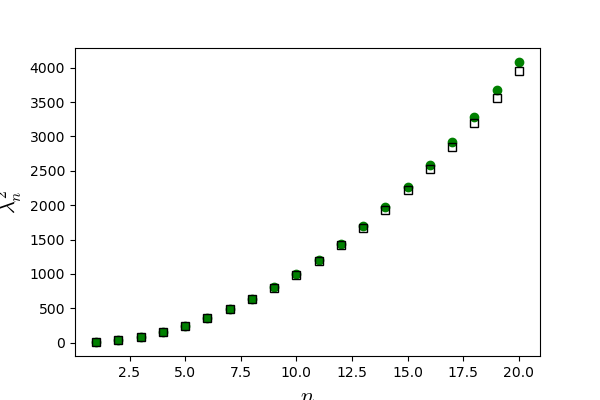

In [9]:
plt.figure(figsize=(6, 4))
plt.plot(range(1, nvals + 1), vals, "o", color="green")
plt.plot(range(1, nvals + 1), vals_ex, "s", mec="black",
         mfc="#FFFFFF00")
plt.xlabel(r"$n$", fontsize=16)
plt.ylabel(r"$\lambda_n^2$", fontsize=16)

Podemos comparar la solución numérica con la solución analítica.

Para ello completamos los vectores propios con los ceros en los extremos
primero.

In [10]:
vecs_comp = np.zeros((N, nvals))
vecs_comp[1:-1, :] = vecs

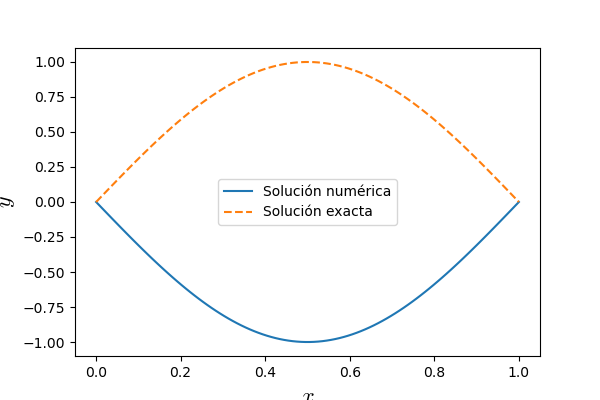

In [11]:
plt.figure(figsize=(6, 4))
plt.plot(x, vecs_comp[:, 0])
plt.plot(x, np.sin(np.pi*x), linestyle="dashed")
plt.xlabel(r"$x$", fontsize=16)
plt.ylabel(r"$y$", fontsize=16)
plt.legend(["Solución numérica", "Solución exacta"])
plt.show()

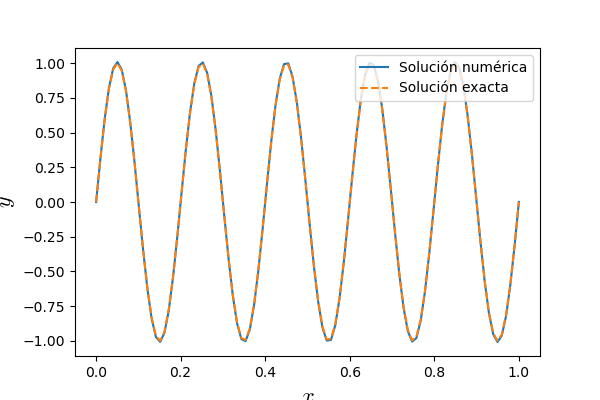

In [12]:
plt.figure(figsize=(6, 4))
plt.plot(x, vecs_comp[:, 9])
plt.plot(x, np.sin(10*np.pi*x), linestyle="dashed")
plt.xlabel(r"$x$", fontsize=16)
plt.ylabel(r"$y$", fontsize=16)
plt.legend(["Solución numérica", "Solución exacta"], loc=1)
plt.show()

## Interpolación

A partir de los vectores propios calculador numéricamente con el
método de elementos finitos podemos usar interpoladores lineales
a tramos (`np.interp`) para evaluar la función en cualquier punto
del dominiio deseado, (0, 1) en este caso.

In [13]:
x_eval = np.linspace(0, 1, 1000)
v_eval = np.interp(x_eval, x, vecs_comp[:, 8])

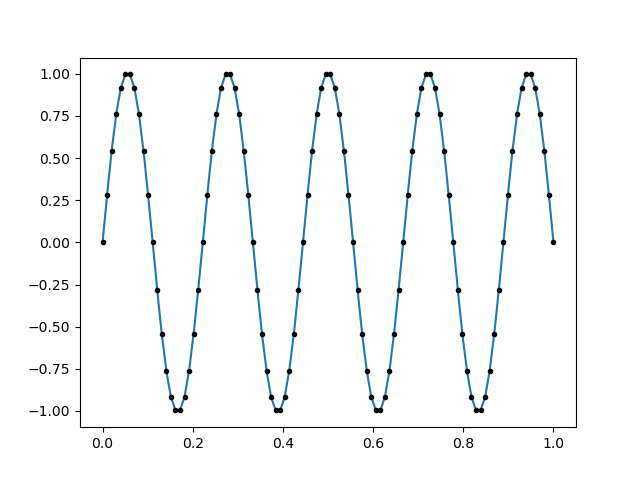

In [14]:
plt.figure()
plt.plot(x_eval, v_eval)
plt.plot(x, vecs_comp[:, 8], ".k")